In [1]:
% matplotlib inline

# Plotting Things
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
print('Setting small-caps')
fontP.set_variant('small-caps')
# matplotlib.rcParams['font.variant'] = 'small-caps'
from matplotlib.ticker import FormatStrFormatter
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
import itertools as it


MARKERS = ('+', 'o', 'v', '^')

# Source: https://stackoverflow.com/questions/43463431/
# custom-logarithmic-axis-scaling-in-matplotlib
class CustomScale(mscale.ScaleBase):
    name = 'custom'
    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self)
        if 'thresh' in kwargs:
            self.thresh = kwargs['thresh']
        else:
            self.thresh = 1.0

    def get_transform(self):
        return self.CustomTransform(self.thresh)

    def set_default_locators_and_formatters(self, axis):
        pass

    class CustomTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def __init__(self, thresh):
            mtransforms.Transform.__init__(self)
            self.thresh = thresh

        def transform_non_affine(self, a):
            # if np.isnan(np.log(self.thresh - a)).any():
            #     print('YYY', a, np.log(self.thresh - a))
            return np.nan_to_num(-1.0 * np.log(self.thresh - a))

        def inverted(self):
            return CustomScale.InvertedCustomTransform(self.thresh)

    class InvertedCustomTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def __init__(self, thresh):
            mtransforms.Transform.__init__(self)
            self.thresh = thresh

        def transform_non_affine(self, a):
            return np.nan_to_num(self.thresh - np.exp(-1.0 * a))

        def inverted(self):
            return CustomScale.CustomTransform(self.thresh)
        
mscale.register_scale(CustomScale)

Setting small-caps


In [2]:
import torch
import torch.nn as nn
import numpy as np

# Load Data
data_path = '../data/processed/'
X = np.load(data_path + 'X.npy')
y = np.load(data_path + 'y.npy')
print("X has shape: {}\ny has shape: {}".format(X.shape, y.shape))
X_torch = torch.from_numpy(X).float()
y_torch = torch.from_numpy(y).float()

# Calculate global optimum a.k.a c from appendix A in the paper
# P.S. @ in python 3.5+ means matrix multiplication
m = len(y_torch)
cross_cov = (1 / m) * y_torch.transpose(0,1) @ X_torch # (1, 128)
y_cov = (1 / m) * y_torch.transpose(0,1) @ y_torch
global_opt = -0.5 * (cross_cov @ cross_cov.transpose(0,1)) + 0.5 * y_cov 
global_opt 

X has shape: (2565, 128)
y has shape: (2565, 1)


tensor([[1.0345]])

In [18]:
import torch
import sys
sys.path.append('../src/models/')
from linear_nn import LinearNet, fro_loss, train
import numpy as np

# Set seed
seed = 521
# seed = 123
torch.manual_seed(seed)
# l = (torch.get_rng_state()) Uncomment this if you want dropout to be the same
# torch.set_rng_state(l)

# Set parameters of the network
num_layers = 3
hidden_widths = 32
d_in = 128
d_out = 1
p = 0.80 # Dropout probability, p = 0 means no dropout
balanced = False
model = LinearNet(num_layers, hidden_widths, d_in, d_out, p)



# Type of initialization
std = 0.03
if balanced:
    init_W = np.random.normal(scale=std, size=[1, 128])
    model.init_balanced(init_W, randomize=False)
else:
    model.init_independent(std)

loss_fn = fro_loss()
learning_rate = 1e-2
train_iter, loss, delta_list, norm_list = train(model, loss_fn, X_torch, y_torch, learning_rate)
print("Training Converged in {} steps.".format(train_iter))

Training Converged in 3407 steps.


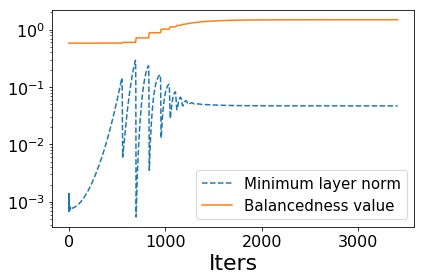

In [19]:
deltas = [max(x) for x in delta_list]
min_norms = [min(x)**2 for x in norm_list]
num_iters = range(len(deltas))

marker = it.cycle(MARKERS)
plt.clf()
plt.plot(num_iters, min_norms, linestyle='dashed')
plt.plot(num_iters, deltas, markersize=10)
plt.xlabel('Iters', fontsize=22)
plt.yscale('log')
plt.legend(['Minimum layer norm', 'Balancedness value'], fontsize=15)
plt.tick_params(axis='y', labelsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tight_layout()

In [5]:
# import matplotlib.pyplot as plt

# iters = range(len(deltas))
# plt.plot(iters, deltas)
# plt.xlabel('Iteration Number')
# plt.ylabel('Delta Value')
# # plt.ylabel('Min L Norm')
# plt.yscale('log')
# plt.title("sigma = {}".format(std))
# print(deltas)

In [6]:
# import matplotlib.pyplot as plt

# iters = range(len(deltas))[100:]
# plt.plot(iters[20:], deltas[20:])
# plt.xlabel('Iteration Number')
# plt.ylabel('Delta Value')
# # plt.ylabel('Min L Norm')
# plt.yscale('log')
# plt.title("sigma = {}".format(std))

In [7]:
# import sys
# sys.path.append('../src/models/')
# from linear_nn import three_layer_nn, fro_loss, train, eight_layer_nn

# # Set seed
# seed = 521
# # seed = 123
# torch.manual_seed(seed)

# # Initalize Constants
# learning_rates = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]
# eps = 1e-5 # Even though they say 1e-5 in the paper, this one works 


# std = 1e-2
# learning_rate = 0.5
# model = three_layer_nn('balance', std) # Bug with dropout, getting delta is going to be a little more subtle
# loss_fn = fro_loss()
# train_iter, loss, deltas, norms = train(model, loss_fn, X_torch, y_torch, learning_rate, eps)
# print(train_iter)
# delta_max, delta_min = max(deltas), min(deltas)
# print(deltas)

In [8]:
# Good result for min layer norms:
# seed = 521, std = 1e-3

In [9]:
# Results of experiments of the above cell, I found a better learning rate than that in the paper
# For a lot of the stds

################################
# Three Layer
################################
# Normal
################################
# std = 1e-4, lr = 0.5, num_iters = 3734
# std = 1e-3, lr = 0.5, num_iters = 381
# std = 1e-2, lr = 0.5, num_iters = 44
# std = 1e-1, lr = 0.5, num_iters = 64
# std = 5e-1, lr = 0.5, num_iters = 17
#################################

################################
# Balanced
################################
# std = 1e-4, lr = 0.5, num_iters = 34
# std = 1e-3, lr = 0.5, num_iters = 19, lr = 1e-2, num_iters = 682 
# std = 1e-2, lr = 0.5, num_iters = 13
# std = 1e-1, lr = 0.5, num_iters = 12
# std = 1, lr = 1e-2, num_iters = 596
#################################

################################
# Eight Layer
################################
# Normal
################################
# std = 1e-4, DNC (Did Not Converge)
# std = 1e-3, DNC
# std = 5e-2, lr = 1e-1, num_iters = 2450
# std = 1e-1, lr = 1e-2, num_iters = 1265
# std = 5e-1, DNC
#################################

################################
# Balanced
################################
# std = 1e-4, lr = 1e-2, num_iters = 2349
# std = 1e-3, lr = 1e-2, num_iters = 681
# std = 1e-2, lr = 1e-2, num_iters = 504
# std = 1e-1, lr = 1e-2, num_iters = 692
# std = 1, lr = 5e-3, num_iters = 1161
#################################